In [50]:
%matplotlib nbagg
import time
import h5py
import matplotlib.pylab as plt
import numpy as np
import dedalus.public as de
from dedalus.extras import flow_tools

In [51]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [52]:
nr = 256

r_in = 5. # cm
r_out = 3*r_in
h = 10. # cm

nu = 3.26e-3 # cm^2/s
eta = 2000 # cm^2/s
rho = 6 # g/cm^3
B0 = 3000 # G

In [53]:
d = r_out - r_in
eps = h/d
K = np.pi/h * np.sqrt(1+eps**2)
Omega_in = 314 # rad/s
Omega_out = 37.9 # rad/s
Re_in = Omega_in/(nu*K**2)
Re_out = Omega_out/(nu*K**2)
zeta_bar = 2*(r_out**2 * Omega_out - r_in**2 * Omega_in)/((r_out**2 - r_in**2)*np.sqrt(Omega_in*Omega_out))
print("Re_in = {}; Re_out = {}".format(Re_in,Re_out))
print("zeta bar = {}".format(zeta_bar))

Re_in = 487957.8476026697; Re_out = 58896.823006819046
zeta bar = 0.062104757527239964


In [56]:
r = de.Chebyshev('r',nr,interval=[r_in, r_out])
domain = de.Domain([r], grid_dtype=np.complex128)

In [57]:
domain.grid(0)

array([  5.00009412,   5.00084709,   5.00235291,   5.00461136,
         5.0076221 ,   5.01138467,   5.0158985 ,   5.02116293,
         5.02717715,   5.03394025,   5.04145123,   5.04970895,
         5.05871216,   5.06845951,   5.07894954,   5.09018065,
         5.10215117,   5.11485929,   5.12830309,   5.14248055,
         5.15738953,   5.17302779,   5.18939298,   5.20648263,
         5.22429416,   5.2428249 ,   5.26207204,   5.28203271,
         5.30270388,   5.32408245,   5.34616519,   5.36894879,
         5.3924298 ,   5.4166047 ,   5.44146984,   5.46702148,
         5.49325576,   5.52016875,   5.54775638,   5.57601451,
         5.60493887,   5.63452511,   5.66476877,   5.69566531,
         5.72721006,   5.75939828,   5.79222511,   5.82568563,
         5.85977477,   5.89448743,   5.92981835,   5.96576223,
         6.00231365,   6.03946711,   6.07721701,   6.11555767,
         6.15448331,   6.19398807,   6.234066  ,   6.27471107,
         6.31591716,   6.35767805,   6.39998746,   6.44

In [58]:
r_g = r.grid()

In [59]:
B = (Omega_out - Omega_in)/(1/r_out**2 - 1/r_in**2)
A = Omega_in - B/r_in**2

Omega = A + B/r_g**2

In [60]:
variables = ['u','v','w','Br','Bphi','Bz','p','vr','wr','Bphi_r']
gmri = de.IVP(domain,variables)
gmri.parameters['nu'] = nu
gmri.parameters['eta'] = eta
gmri.parameters['rho'] = rho
gmri.parameters['u0'] = 1
gmri.parameters['u0r'] = 1
gmri.parameters['B0'] = B0
gmri.parameters['pi'] = np.pi
gmri.parameters['k'] = np.pi/h
gmri.parameters['A'] = A
gmri.parameters['B'] = B
gmri.substitutions['ru0'] = '(r*r*A + B)' # u0 = r Omega(r) = Ar + B/r
gmri.substitutions['rrdu0'] = '(A*r*r-B)' # du0/dr = A - B/r^2

In [61]:
gmri.add_equation("r**2*dt(u) - nu*r**2*(-k**2*u + 1j*k*wr)  + r**2*dr(p)/rho - 2*ru0*v - r**2*B0*1j*k*Br/(4*pi*rho) = 0")
gmri.add_equation("r**2*dt(v) - nu*(r**2*dr(vr) + r*vr - r**2*k**2*v - v) + ru0*u + u*rrdu0 - r**2*B0*1j*k*Bphi/(4*pi*rho) = 0")
gmri.add_equation("r*dt(w) - nu*(r*dr(wr) + wr - r*k**2*w) + r*k*p/rho - r*B0*1j*k*Bz/(4*pi*rho) = 0")
gmri.add_equation("r*dr(u) + u + r*1j*k*w = 0")
gmri.add_equation("vr - dr(v) = 0")
gmri.add_equation("wr - dr(w) = 0")
gmri.add_equation("dt(Br) - eta*(-k**2*Br - 1j*k*dr(Bz)) - B0*1j*k*u = 0")
gmri.add_equation("r**2*dt(Bphi) - eta*(r**2*dr(Bphi_r) - r**2*k**2*Bphi + r*Bphi_r - Bphi) - Br*rrdu0 + ru0*Br - r**2*B0*1j*k*v = 0")
gmri.add_equation("r*dr(Br) + Br + r*1j*k*Bz = 0")
gmri.add_equation("Bphi_r - dr(Bphi) = 0")

In [62]:
# boundary conditions
gmri.add_bc("left(u) = 0")
gmri.add_bc("left(v) = 0")
gmri.add_bc("left(w) = 0")
gmri.add_bc("right(u) = 0")
gmri.add_bc("right(v) = 0")
gmri.add_bc("right(w) = 0")
gmri.add_bc("left(Br) = 0")
gmri.add_bc("right(Br) = 0")
gmri.add_bc("left(dr(r*Bphi)) = 0")
gmri.add_bc("right(dr(r*Bphi)) = 0")

In [63]:
dt = max_dt = 1.
period = 2*np.pi/Omega_in

ts = de.timesteppers.RK443
IVP = gmri.build_solver(ts)
IVP.stop_sim_time = 2000.*period
IVP.stop_wall_time = np.inf
IVP.stop_iteration = 500#00000

2016-05-04 16:01:44,588 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+00/s


In [64]:
print(period)

0.02001014429038085


In [65]:
phi = domain.new_field(name='phi')
phi_z = domain.new_field(name='phi_z')

In [66]:
p = IVP.state['p']
u = IVP.state['u']
v = IVP.state['v']
w = IVP.state['w']
vr = IVP.state['vr']
wr = IVP.state['wr']
Br = IVP.state['Br']
Bphi = IVP.state['Bphi']
Bz = IVP.state['Bz']
for f in [phi,p,u,v,w,vr,wr]:
    f.set_scales(domain.dealias, keep_data=False)

In [67]:
# incompressible perturbation, arbitrary vorticity
k = gmri.parameters['k']

phi['g'] = 1e-3*np.random.randn(*v['g'].shape)*np.sin(np.pi*(r_g - r_in))
phi['c'][nr/3:] = 0
phi.differentiate(0,out=w)
w['g'] += phi['g']/r_g
#w['g'] *= np.sin(np.pi*(r_g - r_in))
w.differentiate(0,out=wr)
u['g'] = k*phi['g']#*np.sin(np.pi*(r_g - r_in))

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [68]:
divu0 = domain.new_field(name='divu0')

u.differentiate(0,out=divu0)
divu0['g'] += u['g']/r_g - k*w['g']

<IPython.core.display.Javascript object>


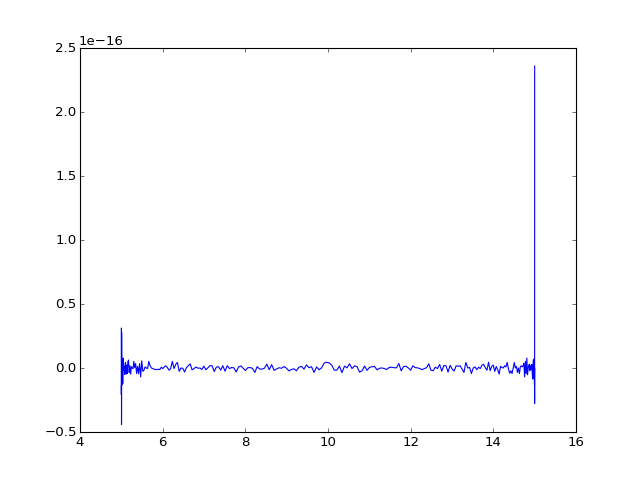

In [69]:
plt.figure()
plt.plot(r_g,divu0['g'])

In [35]:
CFL = flow_tools.CFL(IVP, initial_dt=1e-3, cadence=5, safety=0.3,
                     max_change=1.5, min_change=0.5)
CFL.add_velocities(('u'))

In [70]:
# Integrated energy every 10 iterations
analysis1 = IVP.evaluator.add_file_handler("scalar_data", iter=10)
analysis1.add_task("integ(0.5 * (u*u + v*v + w*w))", name="total kinetic energy")
analysis1.add_task("integ(0.5 * (u*u + w*w))", name="meridional kinetic energy")
analysis1.add_task("integ((u*u)**0.5)", name='u_rms')
analysis1.add_task("integ((w*w)**0.5)", name='w_rms')

# Snapshots every half an inner rotation period
analysis2 = IVP.evaluator.add_file_handler('snapshots',sim_dt=0.5*period, max_size=2**30)
analysis2.add_system(IVP.state, layout='g')

In [71]:
dt = CFL.compute_dt()
# Main loop
start_time = time.time()

while IVP.ok:
    IVP.step(dt)
    if IVP.iteration % 10 == 0:
        logger.info('Iteration: %i, Inner Cylinder Rev: %e, Time: %e, dt: %e' %(IVP.iteration, IVP.sim_time/period,IVP.sim_time, dt))
    dt = CFL.compute_dt()


end_time = time.time()

# Print statistics
logger.info('Total time: %f sec' %(end_time-start_time))
logger.info('Iterations: %i' %IVP.iteration)

2016-05-04 16:01:56,288 __main__ 0/1 INFO :: Iteration: 10, Inner Cylinder Rev: 3.066657e-01, Time: 6.136425e-03, dt: 6.136425e-04
2016-05-04 16:01:58,709 __main__ 0/1 INFO :: Iteration: 20, Inner Cylinder Rev: 6.133315e-01, Time: 1.227285e-02, dt: 6.136425e-04
2016-05-04 16:02:01,072 __main__ 0/1 INFO :: Iteration: 30, Inner Cylinder Rev: 9.199972e-01, Time: 1.840928e-02, dt: 6.136425e-04
2016-05-04 16:02:03,595 __main__ 0/1 INFO :: Iteration: 40, Inner Cylinder Rev: 1.226663e+00, Time: 2.454570e-02, dt: 6.136425e-04
2016-05-04 16:02:05,968 __main__ 0/1 INFO :: Iteration: 50, Inner Cylinder Rev: 1.533329e+00, Time: 3.068213e-02, dt: 6.136425e-04
2016-05-04 16:02:08,351 __main__ 0/1 INFO :: Iteration: 60, Inner Cylinder Rev: 1.839994e+00, Time: 3.681855e-02, dt: 6.136425e-04
2016-05-04 16:02:10,708 __main__ 0/1 INFO :: Iteration: 70, Inner Cylinder Rev: 2.146660e+00, Time: 4.295498e-02, dt: 6.136425e-04
2016-05-04 16:02:13,028 __main__ 0/1 INFO :: Iteration: 80, Inner Cylinder Rev: 2.4

In [72]:
z_g = domain.grid(0)

In [76]:
scale_factor = 2.7/np.abs(v['g']).max()
print("scaling by {}".format(scale_factor))

scaling by 4186.122668483372


<IPython.core.display.Javascript object>


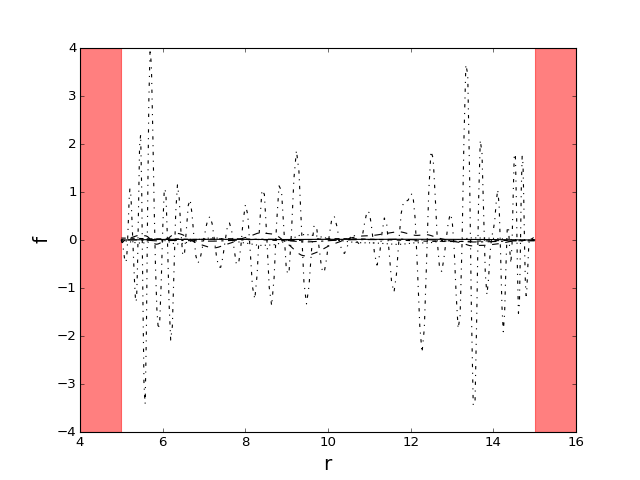

(4, 16)

In [77]:
plt.figure()
plt.plot(z_g,scale_factor*v['g'],'k',ls='--')
plt.plot(z_g,scale_factor*u['g']/3.,'k',ls='dotted')
plt.plot(z_g,scale_factor*w['g']*0.07,'k',ls='-.')
plt.plot(z_g,scale_factor*Br['g']/np.sqrt(4*np.pi*rho),'k')
plt.plot(z_g,scale_factor*Bphi['g']/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4])
plt.plot(z_g,scale_factor*Bz['g']/np.sqrt(4*np.pi*rho),'k',dashes=[4,4])
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4, 5, alpha=0.5, color='red')
plt.axvspan(15, 16, alpha=0.5, color='red')

plt.xlim(4,16)
#plt.ylim(-0.4,0.4)

<IPython.core.display.Javascript object>


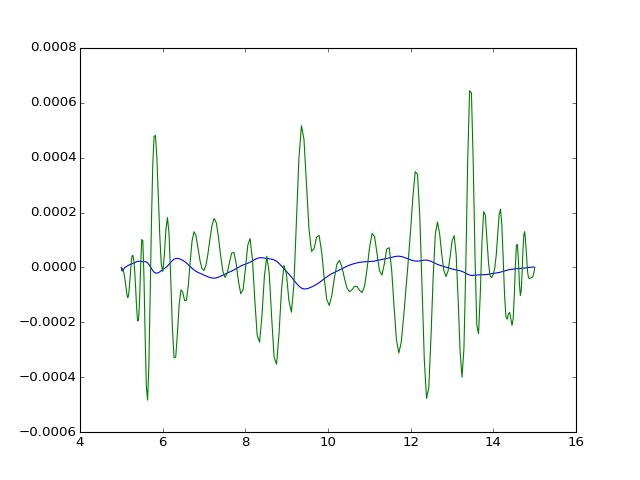

In [75]:
fig = plt.figure()
plt.plot(r_g, v['g'].real)
plt.plot(r_g, v['g'].imag)